In [ ]:
# default_exp engine.gmm_loss

In [ ]:
%load_ext autoreload
%autoreload 2

# Loss function

In [ ]:
#export
from decode_fish.imports import *
from torch import distributions as D, Tensor
from torch.distributions import Distribution
from torch.distributions.utils import _sum_rightmost

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [ ]:
#export
def xyz_log_prob(mix, x):
#     print('spatial')
#     print(x.shape)
    x = mix._pad(x)
#     print(x.shape)
    log_prob_x = mix.component_distribution.base_dist.log_prob(x) 
#     print(log_prob_x.shape)
    log_prob_x = _sum_rightmost(log_prob_x, 1)
#     log_prob_x = log_prob_x.mean(-1)
    log_mix_prob = torch.log_softmax(mix.mixture_distribution.logits, dim=-1) 
    
    return log_prob_x, log_mix_prob

def int_log_prob(mix, x):
#     print('int')    
#     print(x.shape)
    x = mix._pad(x)
    x_bin = torch.where(x > 0, torch.ones_like(x), torch.zeros_like(x))
#     print(x.shape)
    log_prob_x = mix.component_distribution.base_dist.log_prob(x) * x_bin
    print(log_prob_x.shape, x_bin.shape)
#     print(log_prob_x.shape)
    log_prob_x = _sum_rightmost(log_prob_x, 1)
#     log_prob_x = log_prob_x.mean(-1)
    log_mix_prob = torch.log_softmax(mix.mixture_distribution.logits, dim=-1)
 
    return log_prob_x, log_mix_prob

# def ext_log_prob(gauss_mix, bern_mix, x):
    
#     x = gauss_mix._pad(x)
#     x_bin = torch.where(x > 0, torch.ones_like(x), torch.zeros_like(x))
    
#     log_prob_x = gauss_mix.component_distribution.base_dist.log_prob(x) * x_bin 
#     log_prob_x = _sum_rightmost(log_prob_x, 1) 
    
#     bin_prob_x = bern_mix.component_distribution.base_dist.log_prob(x_bin) 
#     bin_prob_x = _sum_rightmost(bin_prob_x, 1)
        
#     return log_prob_x, bin_prob_x

In [ ]:
#export
from einops import rearrange
class PointProcessGaussian(Distribution):
    def __init__(self, logits: torch.tensor,  int_logits: torch.tensor, xyzi_mu: torch.tensor, xyzi_sigma: torch.tensor, **kwargs):
        """ Defines our loss function. Given logits, xyzi_mu and xyzi_sigma 
        
        The count loss first constructs a Gaussian approximation to the predicted number of emitters by summing the mean and the variance of the Bernoulli detection probability map,
        and then maximizes the probability of the true number of emitters under this distribution. 
        The localization loss models the distribution of sub-pixel localizations with a coordinate-wise independent Gaussian probability distribution  with a 3D standard deviation. 
        For imprecise localizations, this probability is maximized for large sigmas, for precise localizations for small sigmas. 
        The distribution of all localizations over the entire image is approximated as a weighted average of individual localization distributions, where the weights correspond to the probability of detection.
        
        Args:
            logits: shape (B,1,D,H,W)
            xyzi_mu: shape (B,4,D,H,W)
            xyzi_sigma: shape (B,4,D,H,W)
        """
        self.logits = logits
        self.int_logits = int_logits
        self.xyzi_mu = xyzi_mu
        self.xyzi_sigma = xyzi_sigma
        
    def log_prob(self, locations, x_offset, y_offset, z_offset, intensities, n_bits, channels, min_int_sig):
        """ Creates the distributions for the count and localization loss and evaluates the log probability for the given set of localizations under those distriubtions.
            Args:
                locations: tuple with voxel locations of inferred emitters
                x_offset, y_offset,z_offset: continuous within pixel offsets. Has lenght of number of emitters in the whole batch.
                intensties: brightness of emitters. Has lenght of number of emitters in the whole batch.
            Returns:
                count_prob: count loss. Has langth of batch_size
                spatial_prob: localizations loss. Has langth of batch_size
        """

        gauss_dim = 3 + channels
        batch_size = self.logits.shape[0]
        if channels == 1:
            xyzi, s_mask = get_true_labels(batch_size, locations, x_offset, y_offset, z_offset, intensities)
        else:
            xyzi, s_mask = get_true_labels_mf(batch_size, n_bits, channels,
                                              locations, x_offset, y_offset, z_offset, intensities)
        counts = s_mask.sum(-1)

        P = torch.sigmoid(self.logits)
        count_mean = P.sum(dim=[2, 3, 4]).squeeze(-1)
        count_var = (P - P ** 2).sum(dim=[2, 3, 4]).squeeze(-1)
        count_dist = D.Normal(count_mean, torch.sqrt(count_var))

        count_prob =  count_dist.log_prob(counts) # * counts

        mixture_probs = P / P.sum(dim=[2, 3, 4], keepdim=True)

        pix_inds = torch.nonzero(P,as_tuple=True)

        xyzi_mu = self.xyzi_mu[pix_inds[0],:,pix_inds[2],pix_inds[3],pix_inds[4]]
        xyzi_mu[:,:3] += torch.stack([pix_inds[4],pix_inds[3],pix_inds[2]], 1) + 0.5
        xyzi_mu = xyzi_mu.reshape(batch_size,-1,gauss_dim)
        xyzi_sig = self.xyzi_sigma[pix_inds[0],:,pix_inds[2],pix_inds[3],pix_inds[4]].reshape(batch_size,-1,gauss_dim)

#         print(xyzi_mu.shape, xyzi.shape)

        mix = D.Categorical(mixture_probs[pix_inds].reshape(batch_size,-1))

        xyzi_sig[:,:,3:] = xyzi_sig[:,:,3:] + min_int_sig
        comp = D.Independent(D.Normal(xyzi_mu, xyzi_sig + 0.00001), 1)
        spatial_gmm = D.MixtureSameFamily(mix, comp)
        spatial_prob = spatial_gmm.log_prob(xyzi.transpose(0, 1)).transpose(0,1)
        spatial_prob = (spatial_prob * s_mask).sum(-1)

        return count_prob, spatial_prob
        
    def log_prob1(self, locations, x_offset, y_offset, z_offset, intensities, n_bits, channels, min_int_sig):
        """ Creates the distributions for the count and localization loss and evaluates the log probability for the given set of localizations under those distriubtions.
        
            Args:
                locations: tuple with voxel locations of inferred emitters
                x_offset, y_offset,z_offset: continuous within pixel offsets. Has lenght of number of emitters in the whole batch.
                intensties: brightness of emitters. Has lenght of number of emitters in the whole batch.
                
            Returns:
                count_prob: count loss. Has langth of batch_size
                spatial_prob: localizations loss. Has langth of batch_size
        """     
        
        gauss_dim = 3 + channels
        batch_size = self.logits.shape[0]
        if channels == 1:
            xyzi, s_mask = get_true_labels(batch_size, locations, x_offset, y_offset, z_offset, intensities)
        else:
            xyzi, s_mask = get_true_labels_mf(batch_size, n_bits, channels, 
                                              locations, x_offset, y_offset, z_offset, intensities)
        counts = s_mask.sum(-1)
        
        P = torch.sigmoid(self.logits) 
        count_mean = P.sum(dim=[2, 3, 4]).squeeze(-1)
        count_var = (P - P ** 2).sum(dim=[2, 3, 4]).squeeze(-1) 
        count_dist = D.Normal(count_mean, torch.sqrt(count_var))
                
        count_prob =  count_dist.log_prob(counts) # * counts
        
        mixture_probs = P / P.sum(dim=[2, 3, 4], keepdim=True)
        
        pix_inds = torch.nonzero(P,as_tuple=True)

        xyzi_mu = self.xyzi_mu[pix_inds[0],:,pix_inds[2],pix_inds[3],pix_inds[4]]
        xyzi_mu[:,:3] += torch.stack([pix_inds[4],pix_inds[3],pix_inds[2]], 1) + 0.5
        xyzi_mu = xyzi_mu.reshape(batch_size,-1,gauss_dim)
        xyzi_sig = self.xyzi_sigma[pix_inds[0],:,pix_inds[2],pix_inds[3],pix_inds[4]].reshape(batch_size,-1,gauss_dim)
        
        mix = D.Categorical(mixture_probs[pix_inds].reshape(batch_size,-1))

        xyz_sl = np.s_[:,:,:3]
        int_sl = np.s_[:,:,3:]
        
        xyzi_sig[int_sl] = xyzi_sig[int_sl] + min_int_sig
        
        comp_xyz = D.Independent(D.Normal(xyzi_mu[xyz_sl], xyzi_sig[xyz_sl] + 0.00001), 1)
        comp_int = D.Independent(D.Normal(xyzi_mu[int_sl], xyzi_sig[int_sl] + 0.00001), 1)
        
        spatial_gmm = D.MixtureSameFamily(mix, comp_xyz)
        int_gmm = D.MixtureSameFamily(mix, comp_int)
        
        spatial_prob, log_mix_prob = xyz_log_prob(spatial_gmm, xyzi[xyz_sl].transpose(0, 1))
        int_prob, _                = xyz_log_prob(int_gmm, xyzi[int_sl].transpose(0, 1))
        
        total_prob = torch.logsumexp(spatial_prob + int_prob + log_mix_prob,-1).transpose(0, 1)
        total_prob = (total_prob * s_mask).sum(-1)
        
        return count_prob, total_prob

    def log_prob2(self, locations, x_offset, y_offset, z_offset, intensities, n_bits, channels, min_int_sig, int_fac=1):
        """ Creates the distributions for the count and localization loss and evaluates the log probability for the given set of localizations under those distriubtions.
        
            Args:
                locations: tuple with voxel locations of inferred emitters
                x_offset, y_offset,z_offset: continuous within pixel offsets. Has lenght of number of emitters in the whole batch.
                intensties: brightness of emitters. Has lenght of number of emitters in the whole batch.
                
            Returns:
                count_prob: count loss. Has langth of batch_size
                spatial_prob: localizations loss. Has langth of batch_size
        """     
        
        gauss_dim = 3 + channels
        batch_size = self.logits.shape[0]
        if channels == 1:
            xyzi, s_mask = get_true_labels(batch_size, locations, x_offset, y_offset, z_offset, intensities)
        else:
            xyzi, s_mask = get_true_labels_mf(batch_size, n_bits, channels, 
                                              locations, x_offset, y_offset, z_offset, intensities)
        counts = s_mask.sum(-1)
        
        P = torch.sigmoid(self.logits) 
        count_mean = P.sum(dim=[2, 3, 4]).squeeze(-1)
        count_var = (P - P ** 2).sum(dim=[2, 3, 4]).squeeze(-1) 
        count_dist = D.Normal(count_mean, torch.sqrt(count_var))
                
        count_prob =  count_dist.log_prob(counts) # * counts
        
        mixture_probs = P / P.sum(dim=[2, 3, 4], keepdim=True)
        
        pix_inds = torch.nonzero(P,as_tuple=True)

        xyzi_mu = self.xyzi_mu[pix_inds[0],:,pix_inds[2],pix_inds[3],pix_inds[4]]
        xyzi_mu[:,:3] += torch.stack([pix_inds[4],pix_inds[3],pix_inds[2]], 1) + 0.5
        xyzi_mu = xyzi_mu.reshape(batch_size,-1,gauss_dim)
        xyzi_sig = self.xyzi_sigma[pix_inds[0],:,pix_inds[2],pix_inds[3],pix_inds[4]].reshape(batch_size,-1,gauss_dim)

#         print(xyzi_mu.shape, xyzi.shape)
        
        mix = D.Categorical(mixture_probs[pix_inds].reshape(batch_size,-1))
        
#         int_P = torch.sigmoid(self.int_logits)[:,:channels]
        
#         int_mean = int_P.sum(dim=[1])
#         int_var = (int_P - int_P ** 2).sum(dim=[1])
#         int_dist = D.Normal(int_mean, torch.sqrt(int_var))
        
#         int_count_prob = (P[:,0].detach() * int_dist.log_prob(torch.ones_like(int_mean).cuda() * n_bits)).mean(dim=[1,2,3])
        
#         int_PP = int_P * P.detach()
#         int_mix = D.Categorical(int_PP[torch.nonzero(int_P,as_tuple=True)].reshape(batch_size,-1))

        int_count_prob = 0
        
        xyz_sl = np.s_[:,:,:3]
        int_sl = np.s_[:,:,3:3+channels]

        comp_xyz = D.Independent(D.Normal(xyzi_mu[xyz_sl], xyzi_sig[xyz_sl] + 0.00001), 1)
        comp_int = D.Independent(D.Normal(xyzi_mu[int_sl], xyzi_sig[int_sl] + min_int_sig), 1)

        spatial_gmm = D.MixtureSameFamily(mix, comp_xyz)
        # int_gmm = D.MixtureSameFamily(int_mix, comp_int)

        spatial_prob, log_mix_prob1 = xyz_log_prob(spatial_gmm, xyzi[xyz_sl].transpose(0, 1))

        ''' '''
        x = xyzi[int_sl].transpose(0, 1)
        x = spatial_gmm._pad(x)
#         x_bin = torch.where(x > 0, torch.ones_like(x), torch.zeros_like(x))
        log_prob_x = comp_int.base_dist.log_prob(x) # * x_bin
        int_prob = _sum_rightmost(log_prob_x, 1)
        log_mix_prob2 = 0
#         log_mix_prob2 = torch.log_softmax(rearrange(int_mix.logits, 'b (ch p) -> b p ch', ch=channels), dim=-1)
#         log_mix_prob2 = _sum_rightmost(log_mix_prob2, 1)
        ''' '''
        total_prob = torch.logsumexp(spatial_prob + log_mix_prob1 + int_prob + log_mix_prob2,-1).transpose(0, 1)

        total_prob = (total_prob * s_mask).sum(-1)
        
        return count_prob+int_count_prob, total_prob

def get_sample_mask(bs, locations):
    
    counts_ = torch.unique(locations[0], return_counts=True)[1]
    batch_loc = torch.unique(locations[0])
    
    counts = torch.cuda.LongTensor(bs).fill_(0)
    counts[batch_loc] = counts_
    
    max_counts = counts.max()
    if max_counts==0: max_counts = 1 #if all 0 will return empty matrix of correct size
    s_arr = cum_count_per_group(locations[0])
    s_mask   = torch.cuda.FloatTensor(bs,max_counts).fill_(0)
    s_mask[locations[0],s_arr] = 1   
    
    return s_mask, s_arr
    
def get_true_labels(bs, locations, x_os, y_os, z_os, *args):
    
    s_mask, s_arr = get_sample_mask(bs, locations)
    max_counts = s_mask.shape[1]
    
    x =  x_os + locations[4].type(torch.cuda.FloatTensor) + 0.5 
    y =  y_os + locations[3].type(torch.cuda.FloatTensor) + 0.5 
    z =  z_os + locations[2].type(torch.cuda.FloatTensor) + 0.5 
    
    gt_vars = torch.stack([x, y, z] + [item for item in args], dim=1)
    gt_list = torch.cuda.FloatTensor(bs,max_counts,gt_vars.shape[1]).fill_(0)
    
    gt_list[locations[0],s_arr] = gt_vars
    return gt_list, s_mask    

def get_true_labels_mf(bs, n_bits, channels, locations, x_os, y_os, z_os, int_ch):
    
    b_inds = torch.cat([torch.tensor([0], device=x_os.device),((x_os[1:] - x_os[:-1]).nonzero() + 1)[:,0], 
                        torch.tensor([len(x_os)], device=x_os.device)])
    n_gt = len(b_inds) - 1
    
    xyz_locs = [l[b_inds[:-1]] for l in locations]
    x_os = x_os[b_inds[:-1]]
    y_os = y_os[b_inds[:-1]]
    z_os = z_os[b_inds[:-1]]
    
    s_mask, s_arr = get_sample_mask(bs, xyz_locs)
    max_counts = s_mask.shape[1]
    
    x =  x_os + xyz_locs[4].type(torch.cuda.FloatTensor) + 0.5 
    y =  y_os + xyz_locs[3].type(torch.cuda.FloatTensor) + 0.5 
    z =  z_os + xyz_locs[2].type(torch.cuda.FloatTensor) + 0.5 
    
    loc_idx = []
    for i in range(n_gt):
        loc_idx += [i] * (b_inds[i+1] - b_inds[i])
    
    intensity = torch.zeros([n_gt, channels]).to(x.device)
    intensity[loc_idx, locations[1]] = int_ch
    
    gt_vars = torch.stack([x, y, z], dim=1)
    gt_vars = torch.cat([gt_vars, intensity], dim=1)
    gt_list = torch.cuda.FloatTensor(bs,max_counts,gt_vars.shape[1]).fill_(0)
    
    gt_list[xyz_locs[0],s_arr] = gt_vars
    return gt_list, s_mask  

def grp_range(counts: torch.Tensor):
    assert counts.dim() == 1

    idx = counts.cumsum(0)
    id_arr = torch.ones(idx[-1], dtype=int, device=counts.device)
    id_arr[0] = 0
    id_arr[idx[:-1]] = -counts[:-1] + 1
    return id_arr.cumsum(0)

def cum_count_per_group(arr):
    """
    Helper function that returns the cumulative sum per group.
    Example:
        [0, 0, 0, 1, 2, 2, 0] --> [0, 1, 2, 0, 0, 1, 3]
    """

    if arr.numel() == 0:
        return arr

    _, cnt = torch.unique(arr, return_counts=True)
    return grp_range(cnt)[np.argsort(np.argsort(arr.cpu().numpy(), kind='mergesort'), kind='mergesort')]

In [ ]:
ppg = PointProcessGaussian(**model_out)
spatial_gmm, gmm_loss = ppg.log_prob(*sim_vars[:5], n_bits=4, channels=16, min_int_sig=0.2)
# spatial_gmm, gmm_loss = ppg.log_prob(locs_3d, x_os_3d.cuda(), y_os_3d.cuda(), z_os_3d.cuda(), ints_3d.cuda(), n_bits=4, channels=16, min_int_sig=0.5, int_fac=4)
print(spatial_gmm)
gmm_loss

tensor([-0.4427, -0.6439,  0.8149,  1.5036,  1.7690,  1.2149, -1.6208],
       device='cuda:0')


tensor([   0.0000, -177.5380,    0.0000,  -62.3007,  -63.2242,    0.0000,
           0.0000], device='cuda:0')

In [ ]:
locations, x_offset, y_offset, z_offset, intensities = sim_vars[:5]
n_bits=4; channels=16; min_int_sig=0.2; int_fac=16

In [ ]:
gauss_dim = 3 + channels
batch_size = ppg.logits.shape[0]
if channels == 1:
    xyzi, s_mask = get_true_labels(batch_size, locations, x_offset, y_offset, z_offset, intensities)
else:
    xyzi, s_mask = get_true_labels_mf(batch_size, n_bits, channels, 
                                      locations, x_offset, y_offset, z_offset, intensities)
counts = s_mask.sum(-1)

P = torch.sigmoid(ppg.logits) 
count_mean = P.sum(dim=[2, 3, 4]).squeeze(-1)
count_var = (P - P ** 2).sum(dim=[2, 3, 4]).squeeze(-1) 
count_dist = D.Normal(count_mean, torch.sqrt(count_var))

count_prob =  count_dist.log_prob(counts) # * counts

mixture_probs = P / P.sum(dim=[2, 3, 4], keepdim=True)

pix_inds = torch.nonzero(P,as_tuple=True)

xyzi_mu = ppg.xyzi_mu[pix_inds[0],:,pix_inds[2],pix_inds[3],pix_inds[4]]
xyzi_mu[:,:3] += torch.stack([pix_inds[4],pix_inds[3],pix_inds[2]], 1) + 0.5
xyzi_mu = xyzi_mu.reshape(batch_size,-1,gauss_dim)
xyzi_sig = ppg.xyzi_sigma[pix_inds[0],:,pix_inds[2],pix_inds[3],pix_inds[4]].reshape(batch_size,-1,gauss_dim)

mix = D.Categorical(mixture_probs[pix_inds].reshape(batch_size,-1))

int_P = torch.sigmoid(ppg.int_logits)[:,:channels]

int_mean = int_P.sum(dim=[1])
int_var = (int_P - int_P ** 2).sum(dim=[1])
int_dist = D.Normal(int_mean, torch.sqrt(int_var))

int_count_prob = (P[:,0].detach() * int_dist.log_prob(torch.ones_like(int_mean).cuda() * n_bits)).mean(dim=[1,2,3])

int_PP = int_P * P.detach()
int_mix = D.Categorical(int_PP[torch.nonzero(int_P,as_tuple=True)].reshape(batch_size,-1))

xyz_sl = np.s_[:,:,:3]
int_sl = np.s_[:,:,3:3+channels]

comp_xyz = D.Independent(D.Normal(xyzi_mu[xyz_sl], xyzi_sig[xyz_sl] + 0.00001), 1)
comp_int = D.Independent(D.Normal(xyzi_mu[int_sl], xyzi_sig[int_sl] + min_int_sig), 1)

spatial_gmm = D.MixtureSameFamily(mix, comp_xyz)
# int_gmm = D.MixtureSameFamily(int_mix, comp_int)

spatial_prob, log_mix_prob1 = xyz_log_prob(spatial_gmm, xyzi[xyz_sl].transpose(0, 1))

''' '''
x = xyzi[int_sl].transpose(0, 1)
x = spatial_gmm._pad(x)
x_bin = torch.where(x > 0, torch.ones_like(x), torch.zeros_like(x))
log_prob_x = comp_int.base_dist.log_prob(x) * x_bin
int_prob = _sum_rightmost(log_prob_x, 1)
log_mix_prob2 = torch.log_softmax(rearrange(int_mix.logits, 'b (ch p) -> b p ch', ch=channels), dim=-1)
log_mix_prob2 = _sum_rightmost(log_mix_prob2, 1)
''' '''
total_prob = torch.logsumexp(spatial_prob + log_mix_prob1 + int_prob + log_mix_prob2,-1).transpose(0, 1)

total_prob = (total_prob * s_mask).sum(-1)

In [ ]:
int_dist

Normal(loc: torch.Size([7, 1, 48, 48]), scale: torch.Size([7, 1, 48, 48]))

In [ ]:
tra = D.Categorical(rearrange(int_PP[pix_inds[0],:,pix_inds[2],pix_inds[3],pix_inds[4]], '(b p) ch -> b (p ch)', b=batch_size))
bla = D.Categorical(int_PP[torch.nonzero(int_P,as_tuple=True)].reshape(batch_size,-1))

In [ ]:
tra = log_mix_prob2

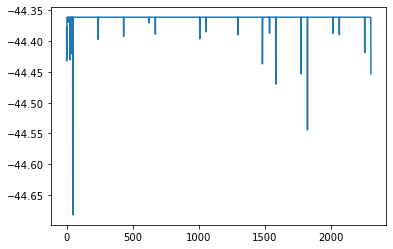

In [ ]:
plt.plot(tra[4,:].sum(-1).cpu())

In [ ]:
int_PP[pix_inds[0],:,pix_inds[2],pix_inds[3],pix_inds[4]].shape

torch.Size([16128, 16])

In [ ]:
mixture_probs[pix_inds].shape

torch.Size([16128])

In [ ]:
int_prob    , log_mix_prob2 = int_log_prob(int_gmm, xyzi[int_sl].transpose(0, 1)[:,:,:10])
# int_prob = rearrange(int_prob, 'n b (p ch) -> n b p ch', ch=channels)

torch.Size([3, 7, 36864, 10]) torch.Size([3, 7, 1, 10])


In [ ]:
xyzi[int_sl].transpose(0, 1).shape

torch.Size([3, 7, 16])

In [ ]:
comp_xyz

Independent(Normal(loc: torch.Size([7, 2304, 3]), scale: torch.Size([7, 2304, 3])), 1)

In [ ]:
comp_int

Independent(Normal(loc: torch.Size([7, 36864, 1]), scale: torch.Size([7, 36864, 1])), 1)

In [ ]:
spatial_gmm.component_distribution.base_dist

Normal(loc: torch.Size([7, 2304, 3]), scale: torch.Size([7, 2304, 3]))

In [ ]:
int_gmm.mixture_distribution.probs.sum(-1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')

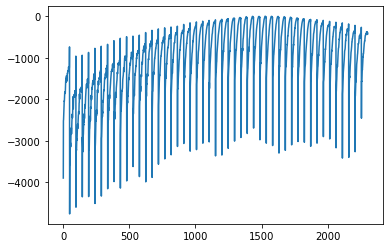

In [ ]:
plt.plot(comp_xyz.log_prob(spatial_gmm._pad((xyzi[xyz_sl].transpose(0,1))))[0,4].cpu())

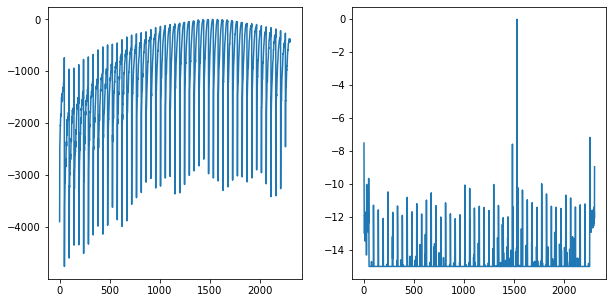

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot((spatial_prob)[0,4].cpu())
plt.subplot(122)
plt.plot((log_mix_prob1)[4].cpu())

In [ ]:
np.argmax((log_mix_prob1)[4].cpu())

tensor(1528)

In [ ]:
mu = xyzi_mu[int_sl][4,1528]
sig = xyzi_sig[int_sl][4,1528]
gt = xyzi[int_sl].transpose(0,1)[0,4]

import torch.tensor as T
logp = torch.distributions.Normal(T(mu[gt.nonzero()[:,0]]), T(sig[gt.nonzero()[:,0]])).log_prob(gt[gt.nonzero()[:,0]])
print(logp, logp.sum())

tensor([-1.5323, -1.8759, -1.7097, -2.9416], device='cuda:0') tensor(-8.0595, device='cuda:0')


/tmp/ipykernel_56556/2928413706.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logp = torch.distributions.Normal(T(mu[gt.nonzero()[:,0]]), T(sig[gt.nonzero()[:,0]])).log_prob(gt[gt.nonzero()[:,0]])


In [ ]:
int_prob[0,4,1528]

tensor(-7.9618, device='cuda:0')

In [ ]:
comp_int.log_prob(int_gmm._pad(xyzi[int_sl].transpose(0,1))).cpu()[0,4].reshape(-1,16)[1528]

tensor([-63.4164, -64.7677, -63.8612, -67.1287, -68.3800, -62.8519, -63.0564,
        -65.9451, -61.5541, -67.5492, -63.4677, -62.2973, -66.1599, -60.0437,
        -59.0938, -60.6916])

In [ ]:
comp_int.log_prob(int_gmm._pad(xyzi[int_sl].transpose(0,1))).cpu()[0,4].shape

torch.Size([36864])

In [ ]:
comp_int.log_prob(int_gmm._pad(xyzi[int_sl].transpose(0,1))).cpu().shape

torch.Size([3, 7, 36864])

In [ ]:
xyzi[int_sl].transpose(0,1).shape

torch.Size([3, 7, 16])

In [ ]:
tra = torch.distributions.Normal(comp_int.base_dist.loc, comp_int.base_dist.scale).log_prob(int_gmm._pad(xyzi[int_sl].transpose(0,1))).reshape(3,7,-1,16,16)

In [ ]:
torch.diag(tra[0,4,1528]).cpu()[gt.nonzero()[:,0]]

tensor([-1.6202, -1.8732, -1.7483, -2.7201])

In [ ]:
mu = xyzi_mu[xyz_sl][4,1528]
sig = xyzi_sig[xyz_sl][4,1528]
gt = xyzi[xyz_sl].transpose(0,1)[0,4]

import torch.tensor as T
logp = torch.distributions.Normal(T(mu[gt.nonzero()[:,0]]), T(sig[gt.nonzero()[:,0]])).log_prob(gt[gt.nonzero()[:,0]])
print(logp, logp.sum())

tensor([ 0.3336,  1.1125, -0.9189], device='cuda:0') tensor(0.5272, device='cuda:0')


/tmp/ipykernel_56556/1467059899.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logp = torch.distributions.Normal(T(mu[gt.nonzero()[:,0]]), T(sig[gt.nonzero()[:,0]])).log_prob(gt[gt.nonzero()[:,0]])


In [ ]:
comp_xyz.log_prob(spatial_gmm._pad(xyzi[xyz_sl].transpose(0,1))).cpu()[0,4,1528]

tensor(0.5271)

In [ ]:
log_mix_prob2.shape

torch.Size([7, 2304])

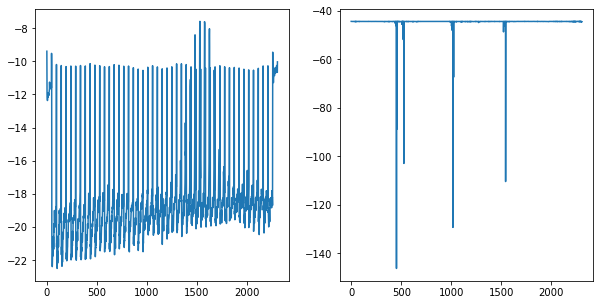

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot((int_prob)[0,4].cpu())
plt.subplot(122)
plt.plot((log_mix_prob2)[4].cpu())

In [ ]:
torch.argmax(log_mix_prob2[4])

tensor(2253, device='cuda:0')

In [ ]:
spatial_prob.shape

torch.Size([3, 7, 2304])

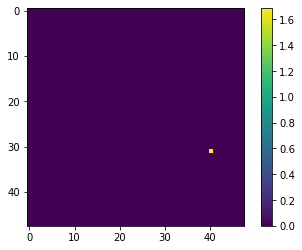

In [ ]:
plt.imshow(torch.exp(spatial_prob+log_mix_prob1)[0,4].cpu().reshape([48,-1]))
plt.colorbar()

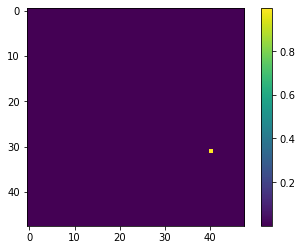

In [ ]:
plt.imshow(torch.exp(log_mix_prob1)[4].cpu().reshape([48,-1]))
plt.colorbar()

In [ ]:
torch.logsumexp(spatial_prob,-1).transpose(0, 1) * s_mask

tensor([[-0.0000, -0.0000, -0.0000],
        [0.8051, 1.7006, 1.2011],
        [-0.0000, -0.0000, -0.0000],
        [0.8855, -0.0000, -0.0000],
        [1.1286, -0.0000, -0.0000],
        [-0.0000, -0.0000, -0.0000],
        [-0.0000, -0.0000, -0.0000]], device='cuda:0')

In [ ]:
torch.logsumexp(int_prob ,-1).transpose(0, 1)  * s_mask

tensor([[   0.0000,    0.0000,    0.0000],
        [-430.6706, -845.0146, -710.6526],
        [   0.0000,    0.0000,    0.0000],
        [-817.6026,    0.0000,    0.0000],
        [-845.3740,    0.0000,    0.0000],
        [   0.0000,    0.0000,    0.0000],
        [   0.0000,    0.0000,    0.0000]], device='cuda:0')

In [ ]:
s_mask.shape

torch.Size([7, 3])

In [ ]:
int_count_prob.shape

torch.Size([7, 48])

In [ ]:
count_prob.shape

torch.Size([7])

In [ ]:
(int_dist.log_prob(torch.ones_like(int_mean).cuda() * n_bits)*P).sum()

tensor(7259.4150, device='cuda:0')

In [ ]:
ppg = PointProcessGaussian(**model_out)
spatial_prob, log_mix_prob1, int_prob, log_mix_prob2 = ppg.log_prob(*sim_vars[:5], n_bits=4, channels=16, min_int_sig=.2, int_fac=16)
print(spatial_prob.mean())

tensor(-8857.0488, device='cuda:0')


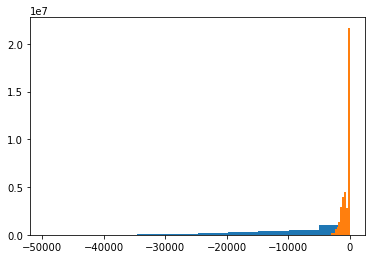

In [ ]:
_= plt.hist(np.array(spatial_prob.reshape(-1).cpu().detach()))
_= plt.hist(np.array(int_prob.reshape(-1).cpu().detach()))

In [ ]:
int_prob.min()

tensor(-3072.4915, device='cuda:0')

In [ ]:
model_out = torch.load('../data/model_batch_output_code_int_p.pt')
sim_vars = torch.load('../data/sim_var_code_int_p.pt')

In [ ]:
model_out.keys()

dict_keys(['logits', 'xyzi_mu', 'xyzi_sigma', 'background', 'int_logits', 'Probs_si', 'Samples_si'])

In [ ]:
model_out = torch.load('../data/model_batch_output_code_int_p.pt')
for k in model_out:
    model_out[k] = model_out[k].to('cuda') 
model_out.keys()
# model_out['logits'].shape

dict_keys(['logits', 'xyzi_mu', 'xyzi_sigma', 'background', 'int_logits', 'Probs_si', 'Samples_si'])

In [ ]:
from decode_fish.engine.point_process import PointProcessUniform
point_process = PointProcessUniform(local_rate = torch.ones([2,1,48,48,48])*.001, int_conc=1.0, sim_iters=5, channels=16, n_bits=4)
locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape = point_process.sample(phasing=False)

In [ ]:
locs_3d = [l.cuda() for l in locs_3d]
# xyzi_true, s_mask = get_true_labels(2, locs_3d, x_os_3d.cuda(), y_os_3d.cuda(), z_os_3d.cuda(), ints_3d.cuda())
xyzi_true, s_mask = get_true_labels_mf(2, 4, 16, locs_3d, x_os_3d.cuda(), y_os_3d.cuda(), z_os_3d.cuda(), ints_3d.cuda())
print(len(locs_3d[0]))
print(s_mask)
print(s_mask.sum(-1))

NameError: name 'get_true_labels_mf' is not defined

In [ ]:
ppg = PointProcessGaussian(**model_out)
gmm_loss = ppg.log_prob(locs_3d, x_os_3d.cuda(), y_os_3d.cuda(), z_os_3d.cuda(), ints_3d.cuda(), n_bits=4, channels=16, min_int_sig=0.1)
gmm_loss

torch.Size([2]) torch.Size([])
torch.Size([2, 2304]) torch.Size([3])
torch.Size([2, 2304]) torch.Size([])
torch.Size([2, 2304, 16]) torch.Size([1])
torch.Size([2]) torch.Size([3])
torch.Size([2, 2304]) torch.Size([1])
torch.Size([116, 2, 1, 3])
torch.Size([116, 2, 1, 16])


RuntimeError: The size of tensor a (2) must match the size of tensor b (2304) at non-singleton dimension 1

In [ ]:
ints_3d.cuda()

tensor([1.4218, 0.1334, 1.1148,  ..., 0.1914, 1.5103, 0.0080], device='cuda:0')

In [ ]:
# for i in range(1000):
#     gmm_loss = PointProcessGaussian(**model_out).log_prob(locs_3d, x_os_3d.cuda(), y_os_3d.cuda(), z_os_3d.cuda(), ints_3d.cuda())

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 20_MERFISH_visualization.ipynb.
Converted 22_MERFISH_codenet.ipynb.
Converted index.ipynb.
